In [216]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [217]:
def get_ranks(filename):
    # WriterTimes-meso-12.48+4.4-8162993-nekRS.1.csv
    res = filename.split('-')[-3].split('+')
    ranks = res[0].split('.')[1]
    # nodes = res[0].split('.')[0]
    return ranks

In [218]:
# Read the Timer Profiling data

# Directory path containing the files
directory = 'data'

# List to store individual DataFrames
dataframes = []

# categories
categories = ["catalyst", "posthocio", "no_sensei"]
sites = ['jsc']

# Iterate over each file in the directory
for site in sites:
    for cat in categories:
        path = os.path.join(directory, site, cat)
        for filename in os.listdir(path):
            if "Times" in filename and filename.endswith(".csv"):
                print(filename)
                ranks = get_ranks(filename)
                file_path = os.path.join(path, filename)
                data = pd.read_csv(file_path)
                data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('#_', '').str.lower()
                data['total_ranks'] = ranks
                data['category'] = cat
                data['site'] = site
                dataframes.append(data)

# Concatenate the DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Convert 'Total Ranks' to integers
df['total_ranks'] = df['total_ranks'].astype(int)
result = df

WriterTimes-meso-16.64+4.4-8197183-nekRS.2.csv
WriterTimes-meso-32.128+8.8-8197154-nekRS.2.csv
WriterTimes-meso-8.32+2.2-8196197-nekRS.2.csv
WriterTimes-meso-64.256+16.16-8197701-nekRS.2.csv
WriterTimes-meso-16.64+4.4-8197183-nekRS.1.csv
WriterTimes-meso-8.32+2.2-8196197-nekRS.1.csv
WriterTimes-meso-64.256+16.16-8197701-nekRS.1.csv
WriterTimes-meso-8.32+2.2-8196197-endpoint.1.csv
WriterTimes-meso-32.128+8.8-8197154-nekRS.1.csv
WriterTimes-meso-64.256+16.16-8197701-nekRS.nosensei.csv
WriterTimes-meso-16.64+4.4-8197183-nekRS.nosensei.csv
WriterTimes-meso-32.128+8.8-8197154-nekRS.nosensei.csv
WriterTimes-meso-8.32+2.2-8196197-nekRS.nosensei.csv


In [219]:
result.head()

,rank,thread,name,start_time,end_time,delta,bytes,depth,total_ranks,category,site
0,0,22386744500224,"""ADIOS2AnalysisAdaptor::Initialize""",1.691699e+09,1.691699e+09,0.000140,-1,3,64,catalyst,jsc
1,0,22386744500224,"""ADIOS2AnalysisAdaptor::0::Initialize""",1.691699e+09,1.691699e+09,0.000005,-1,3,64,catalyst,jsc
2,0,22386744500224,"""ConfigurableAnalysis::Initialize""",1.691699e+09,1.691699e+09,0.000366,-1,2,64,catalyst,jsc
3,0,22386744500224,"""ConfigurableAnalysis::Initialize""",1.691699e+09,1.691699e+09,0.000585,-1,1,64,catalyst,jsc
4,0,22386744500224,"""nek::sensei_bridge::initialize""",1.691699e+09,1.691699e+09,0.001163,-1,0,64,catalyst,jsc


# Mean time per timestep

In [220]:
# Group the data by 'name' and 'rank' and calculate the mean 'delta' values for the desired columns
# grouped_data = df[result['name'].str.contains('ADIOS2AnalysisAdaptor::Execute|ADIOS2AnalysisAdaptor::Initialize|ADIOS2AnalysisAdaptor::Finalize')]
grouped_data = df[result['name'].str.contains('nek::sensei_bridge::update')] # nek::sensei_bridge::initialize|nek::sensei_bridge::finalize')]
grouped_data = grouped_data.groupby(['name', 'total_ranks', 'category', 'site'])['delta'].mean().reset_index()

grouped_data.head()

,name,total_ranks,category,site,delta
0,"""nek::sensei_bridge::update""",32,catalyst,jsc,1.167467
1,"""nek::sensei_bridge::update""",32,no_sensei,jsc,0.000004
2,"""nek::sensei_bridge::update""",32,posthocio,jsc,1.209115
3,"""nek::sensei_bridge::update""",64,catalyst,jsc,1.185520
4,"""nek::sensei_bridge::update""",64,no_sensei,jsc,0.000004


In [221]:
df = grouped_data[grouped_data['site'] == 'jsc']

In [203]:
no_sensei = df[df['category'] == 'no_sensei']
no_sensei = no_sensei.pivot(index='total_ranks', columns='name', values='delta')
no_sensei.sort_index(ascending=True, inplace=True)
no_sensei.head()

name,"""nek::sensei_bridge::update"""
total_ranks,
32,0.000004
64,0.000004
128,0.000004
256,0.000004


In [204]:
catalyst = df[df['category'] == 'catalyst']
catalyst = catalyst.pivot(index='total_ranks', columns='name', values='delta')
catalyst.sort_index(ascending=True, inplace=True)
catalyst.head()

name,"""nek::sensei_bridge::update"""
total_ranks,
32,1.167467
64,1.185520
128,1.184717
256,1.196338


In [205]:
posthocio = df[df['category'] == 'posthocio']
posthocio = posthocio.pivot(index='total_ranks', columns='name', values='delta')
posthocio.sort_index(ascending=True, inplace=True)
posthocio.head()

name,"""nek::sensei_bridge::update"""
total_ranks,
32,1.209115
64,1.225309
128,1.182931
256,1.196919


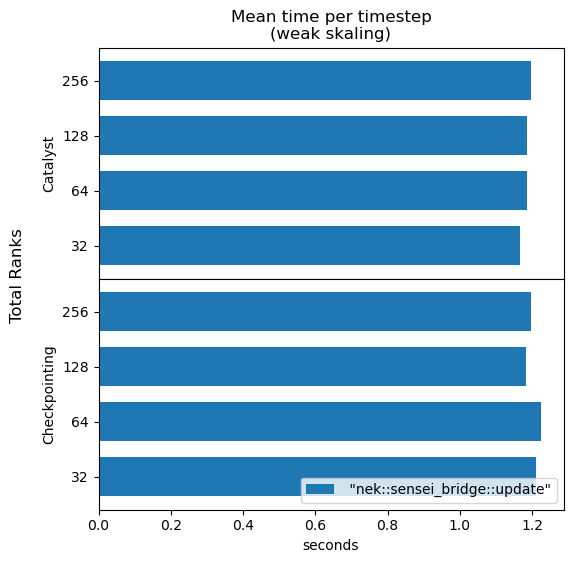

In [207]:
%matplotlib inline
def plot_mean_time_per_timestep(df):
    catalyst = df[df['category'] == 'catalyst']
    posthocio = df[df['category'] == 'posthocio']
    no_sensei = df[df['category'] == 'no_sensei']

    # Pivot the data to have 'rank' as columns and 'name' as index
    catalyst = catalyst.pivot(index='total_ranks', columns='name', values='delta')
    posthocio = posthocio.pivot(index='total_ranks', columns='name', values='delta')
    no_sensei = no_sensei.pivot(index='total_ranks', columns='name', values='delta')

    # Sort the index in ascending order
    catalyst.sort_index(ascending=True, inplace=True)
    posthocio.sort_index(ascending=True, inplace=True)
    no_sensei.sort_index(ascending=True, inplace=True)

    fig, axs = plt.subplots(2, figsize=(6,6), sharex=True)

    # Plot the stacked bar graph with axes flipped
    catalyst.plot(ax=axs[0], kind='barh', stacked=True, width=0.7)
    posthocio.plot(ax=axs[1], kind='barh', stacked=True, width=0.7)
    #no_sensei.plot(ax=axs[2], kind='barh', stacked=True)

    # Bring subplots close to each other.
    fig.subplots_adjust(hspace=0)
    fig.suptitle('Total Ranks', rotation="vertical", x = -0.01, y=0.5, va="center", ha="center")

    for ax in axs:
        ax.yaxis.set_label_position('left')
        ax.label_outer()
    axs[1].get_legend().set_title('')
    axs[1].legend(loc='lower right')
    axs[0].get_legend().remove()
    # axs[2].get_legend().remove()
    
    # Set the title and labels
    axs[0].set_title('Mean time per timestep\n(weak skaling)')
    axs[0].set_ylabel("Catalyst")
    axs[1].set_ylabel("Checkpointing")
    #axs[2].set_ylabel("No Transport")

    #axs[0].set_xlabel("seconds")
    axs[1].set_xlabel("seconds")
    #axs[2].set_xlabel("seconds")

    # Show the plot
    plt.show()
    
plot_mean_time_per_timestep(grouped_data[grouped_data['site'] == 'jsc'])

# Average Memory per rank

In [208]:
dataframes = []
# Iterate over each file in the directory
for site in sites:
    for cat in categories:
        path = os.path.join(directory, site, cat)
        for filename in os.listdir(path):
            if "MemProf" in filename and filename.endswith(".csv"):
                print(filename)
                ranks = get_ranks(filename)
                file_path = os.path.join(path, filename)
                data = pd.read_csv(file_path)
                data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('#_', '').str.lower()
                data['total_ranks'] = ranks
                data['category'] = cat
                data['site'] = site
                dataframes.append(data)

# Concatenate the DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Convert 'Total Ranks' to integers
df['total_ranks'] = df['total_ranks'].astype(int)

# Covert to MB
df['memory_mb'] = df['memory_kib'] / 1024

# Covert to GB
df['memory_gb'] = df['memory_mb'] / 1024


WriterMemProf-meso-16.64+4.4-8197183-nekRS.2.csv
WriterMemProf-meso-8.32+2.2-8196197-nekRS.2.csv
WriterMemProf-meso-64.256+16.16-8197701-nekRS.2.csv
WriterMemProf-meso-32.128+8.8-8197154-nekRS.2.csv
WriterMemProf-meso-64.256+16.16-8197701-nekRS.1.csv
WriterMemProf-meso-8.32+2.2-8196197-nekRS.1.csv
WriterMemProf-meso-16.64+4.4-8197183-nekRS.1.csv
WriterMemProf-meso-8.32+2.2-8196197-endpoint.1.csv
WriterMemProf-meso-32.128+8.8-8197154-nekRS.1.csv
WriterMemProf-meso-16.64+4.4-8197183-nekRS.nosensei.csv
WriterMemProf-meso-64.256+16.16-8197701-nekRS.nosensei.csv
WriterMemProf-meso-32.128+8.8-8197154-nekRS.nosensei.csv
WriterMemProf-meso-8.32+2.2-8196197-nekRS.nosensei.csv


In [209]:
df.head()

,rank,time,memory_kib,total_ranks,category,site,memory_mb,memory_gb
0,0,1.691699e+09,16370164,64,catalyst,jsc,15986.488281,15.611805
1,0,1.691699e+09,18036760,64,catalyst,jsc,17614.023438,17.201195
2,0,1.691699e+09,19979508,64,catalyst,jsc,19511.238281,19.053944
3,0,1.691699e+09,19931168,64,catalyst,jsc,19464.031250,19.007843
4,0,1.691699e+09,18935336,64,catalyst,jsc,18491.539062,18.058144


In [210]:
# Group the DataFrame by 'total_ranks' and calculate the average per time, then sum the values
sum_avg_memory = df.groupby(['total_ranks', 'category', 'site'])['memory_gb'].mean().reset_index()
#sum_avg_memory.sort_index(ascending=True, inplace=True)
sum_avg_memory.head()

,total_ranks,category,site,memory_gb
0,32,catalyst,jsc,17.981127
1,32,no_sensei,jsc,16.974673
2,32,posthocio,jsc,18.616500
3,64,catalyst,jsc,16.536608
4,64,no_sensei,jsc,15.960463


In [211]:
out = sum_avg_memory[sum_avg_memory['category'] == 'catalyst']
out.head()

,total_ranks,category,site,memory_gb
0,32,catalyst,jsc,17.981127
3,64,catalyst,jsc,16.536608
6,128,catalyst,jsc,16.162854
9,256,catalyst,jsc,16.016584


In [212]:
df.head()

,rank,time,memory_kib,total_ranks,category,site,memory_mb,memory_gb
0,0,1.691699e+09,16370164,64,catalyst,jsc,15986.488281,15.611805
1,0,1.691699e+09,18036760,64,catalyst,jsc,17614.023438,17.201195
2,0,1.691699e+09,19979508,64,catalyst,jsc,19511.238281,19.053944
3,0,1.691699e+09,19931168,64,catalyst,jsc,19464.031250,19.007843
4,0,1.691699e+09,18935336,64,catalyst,jsc,18491.539062,18.058144


In [213]:
catalyst = sum_avg_memory[sum_avg_memory['category'] == 'catalyst']
catalyst.head()


,total_ranks,category,site,memory_gb
0,32,catalyst,jsc,17.981127
3,64,catalyst,jsc,16.536608
6,128,catalyst,jsc,16.162854
9,256,catalyst,jsc,16.016584


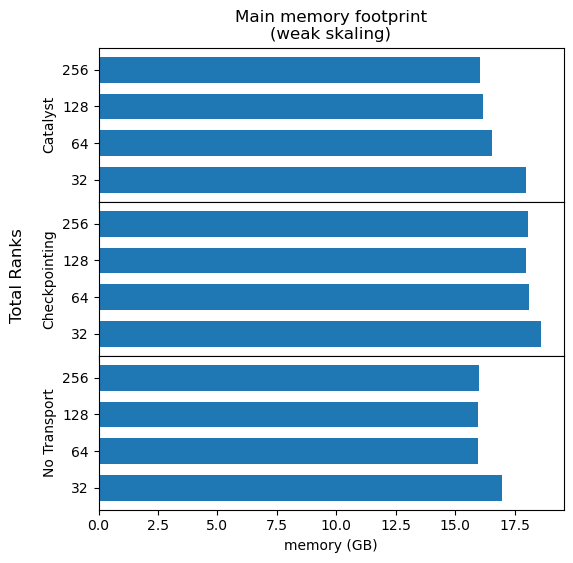

In [215]:
def plot_mean_memory_per_timestep(df):
    catalyst = sum_avg_memory[sum_avg_memory['category'] == 'catalyst']
    posthocio = sum_avg_memory[sum_avg_memory['category'] == 'posthocio']
    no_sensei = sum_avg_memory[sum_avg_memory['category'] == 'no_sensei']

    # Sort the index in ascending order
    catalyst.sort_index(ascending=True, inplace=True)
    posthocio.sort_index(ascending=True, inplace=True)
    no_sensei.sort_index(ascending=True, inplace=True)

    fig, axs = plt.subplots(3, figsize=(6,6), sharex=True)

    # Plot the stacked bar graph with axes flipped
    catalyst.plot(ax=axs[0], kind='barh', x='total_ranks', y='memory_gb', width=0.7)
    posthocio.plot(ax=axs[1], kind='barh', x='total_ranks', y='memory_gb', width=0.7)
    no_sensei.plot(ax=axs[2], kind='barh', x='total_ranks', y='memory_gb', width=0.7)

    # Bring subplots close to each other.
    fig.subplots_adjust(hspace=0)
    fig.suptitle('Total Ranks', rotation="vertical", x = -0.01, y=0.5, va="center", ha="center")

    for ax in axs:
        ax.yaxis.set_label_position('left')
        ax.get_legend().remove()
        ax.label_outer()

    # Set the title and labels
    axs[0].set_title('Main memory footprint\n(weak skaling)')
    axs[0].set_ylabel("Catalyst")
    axs[1].set_ylabel("Checkpointing")
    axs[2].set_ylabel("No Transport")

    axs[2].set_xlabel("memory (GB)")
    plt.show()


plot_mean_memory_per_timestep(sum_avg_memory[sum_avg_memory['site'] == 'julich'])

In [ ]:
#XXXX THIS IS INCORRECT DISREGARD EVERYTHING BELOW THIS LINE

In [ ]:
# Group the DataFrame by 'total_ranks' and calculate the average per time, then sum the values
sum_avg_memory = df.groupby(['total_ranks', 'category'])['memory_gb'].sum().reset_index()
catalyst = sum_avg_memory[sum_avg_memory['category'] == 'catalyst']
posthocio = sum_avg_memory[sum_avg_memory['category'] == 'posthocio']
no_sensei = sum_avg_memory[sum_avg_memory['category'] == 'no_sensei']

# Sort the index in ascending order
catalyst.sort_index(ascending=True, inplace=True)
posthocio.sort_index(ascending=True, inplace=True)
no_sensei.sort_index(ascending=True, inplace=True)

fig, axs = plt.subplots(3, figsize=(6,8))

# Plot the stacked bar graph with axes flipped
catalyst.plot(ax=axs[0], kind='barh', x='total_ranks', y='memory_gb')
posthocio.plot(ax=axs[1], kind='barh', x='total_ranks', y='memory_gb')
no_sensei.plot(ax=axs[2], kind='barh', x='total_ranks', y='memory_gb')

# Bring subplots close to each other.
fig.subplots_adjust(hspace=0)
fig.suptitle('Total Ranks', rotation="vertical", x = -0.01, y=0.5, va="center", ha="center")

for ax in axs:
    ax.yaxis.set_label_position('left')
    ax.get_legend().remove()
    ax.label_outer()

# Set the title and labels
axs[0].set_title('Total Memory footprint for all ranks')
axs[0].set_ylabel("Catalyst")
axs[1].set_ylabel("PosthocIO")
axs[2].set_ylabel("Without SENSEI")

axs[2].set_xlabel("Sum of memory accross ranks(GB)")

# Show the plot
plt.show()

In [ ]:
sum_memory = result.groupby(['time', 'total_ranks'])['memory_kib'].sum()

In [ ]:
result[result['total_ranks'] == 4]

In [ ]:
memory_usage = {}
total_ranks = pd.unique(result['total_ranks'])

index = 0
for rank in total_ranks:
    df = result[result['total_ranks'] == rank]
    N = df[df['rank'] == 0].count()['rank']
    res = df['memory_kib'].values.reshape(-1, N)
    total_sum = [sum(x) for x in zip(*res)]

    timestep = 0
    for ts in total_sum:
        memory_usage[str(index)] = {'total_ranks': rank, 'memory_kib': ts, 'timestep': timestep}
        timestep = timestep + 1
        index = index + 1
#memory_usage
memory_df = pd.DataFrame(memory_usage).transpose()
# Covert to MB
memory_df['memory_mb'] = memory_df['memory_kib'] / 1024

# Covert to GB
memory_df['memory_gb'] = memory_df['memory_mb'] / 1024

In [ ]:
# Group the DataFrame by 'total_ranks' and calculate the average per time, then sum the values
sum_avg_memory = memory_df.groupby('total_ranks')['memory_gb'].mean().reset_index()

# Convert 'Total Ranks' to integers
sum_avg_memory['total_ranks'] = sum_avg_memory['total_ranks'].astype(int)

# Sort the index in ascending order
sum_avg_memory = sum_avg_memory.sort_values('total_ranks')


# Plot the sum of average memory_gb over time by 'total_ranks' with axes flipped
sum_avg_memory.plot(kind='barh', x='total_ranks', y='memory_gb')
#plt.barh()

# Set the title and labels
plt.title('Total Memory footprint for all ranks')
plt.xlabel('Sum of memory accross ranks(GB)')
plt.ylabel('Total Ranks')

# Show the plot
plt.show()

In [ ]:
memory_df.groupby('total_ranks')['memory_gb'].mean().reset_index()